In [22]:
import pandas as pd

data = pd.read_csv("SBER 1h.csv")

data.begin = pd.to_datetime(data.begin)
data.end = pd.to_datetime(data.end)

In [72]:
from catboost import CatBoostClassifier

train_data = data[data.begin < pd.to_datetime("2023-01-01 00:00:00")]
test_data = data[data.begin >= pd.to_datetime("2023-01-01 00:00:00")]

X_train = train_data[['open', 'close', 'high', 'low', 'value', 'volume']]
Y_train = train_data.high > train_data.open * 1.002
Y_train.shift()

model = CatBoostClassifier()
model.fit(X_train, Y_train)


Learning rate set to 0.043803
0:	learn: 0.6822548	total: 7.76ms	remaining: 7.75s
1:	learn: 0.6721936	total: 15ms	remaining: 7.5s
2:	learn: 0.6639296	total: 22.5ms	remaining: 7.48s
3:	learn: 0.6576054	total: 29.6ms	remaining: 7.37s
4:	learn: 0.6498824	total: 35.8ms	remaining: 7.12s
5:	learn: 0.6443285	total: 42.5ms	remaining: 7.03s
6:	learn: 0.6395655	total: 48.7ms	remaining: 6.91s
7:	learn: 0.6350865	total: 54.8ms	remaining: 6.79s
8:	learn: 0.6298223	total: 60.9ms	remaining: 6.71s
9:	learn: 0.6255322	total: 67.1ms	remaining: 6.64s
10:	learn: 0.6219512	total: 73.4ms	remaining: 6.6s
11:	learn: 0.6187281	total: 80.6ms	remaining: 6.63s
12:	learn: 0.6161129	total: 86.5ms	remaining: 6.57s
13:	learn: 0.6134113	total: 93.8ms	remaining: 6.61s
14:	learn: 0.6111486	total: 99.5ms	remaining: 6.53s
15:	learn: 0.6086838	total: 106ms	remaining: 6.52s
16:	learn: 0.6063587	total: 113ms	remaining: 6.52s
17:	learn: 0.6048622	total: 119ms	remaining: 6.48s
18:	learn: 0.6029049	total: 126ms	remaining: 6.52s


1.002 0.5 0.7581364182842539
1.002 0.6 0.9098399899240808
1.002 0.7 0.9679760609643286
1.002 0.8 1.0372800403539115
1.002 0.9 1.0036043217280002
1.003 0.5 0.7458898112196759
1.003 0.6 0.9524259011192482
1.003 0.7 1.0329692919626645
1.003 0.8 1.0410068012503249
1.003 0.9 1.0066145306479999
1.005 0.5 0.8372024043559385
1.005 0.6 1.0964764968251897
1.005 0.7 1.1572602732820232
1.005 0.8 1.115882942508324
1.005 0.9 1.012652994088
1.01 0.5 0.8715822069528623
1.01 0.6 1.1612435153894878
1.01 0.7 1.267535523156208
1.01 0.8 1.204024207463473
1.01 0.9 1.022795773834952


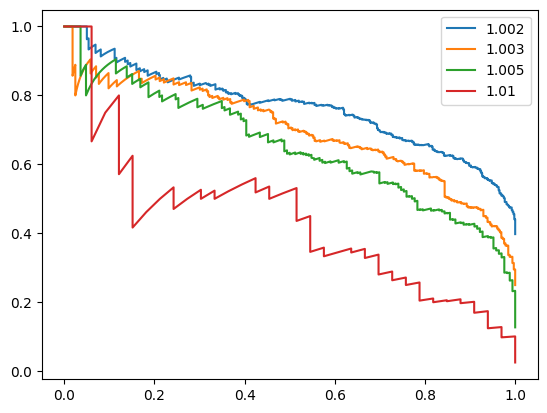

In [77]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

commission = 0.0008
for req_increase in [1.002, 1.003, 1.005, 1.01]:
    X_test = test_data[['open', 'close', 'high', 'low', 'value', 'volume']]
    Y_test = test_data.high > test_data.open * req_increase
    Y_test.shift()

    y_pred = model.predict_proba(X_test)
    precision, recall, _ = precision_recall_curve(Y_test, y_pred[:, 1])
    plt.plot(recall, precision)
    for required_certainity in [0.5, 0.6, 0.7, 0.8, 0.9]:

        balance = 1

        for i in range(Y_test.shape[0]):
            if Y_test.iloc[i] and y_pred[i, 1] > required_certainity:
                balance *= req_increase - commission # substract the commission for 2 trades
            if Y_test.iloc[i] == 0 and y_pred[i, 1] > required_certainity:
                balance *= (X_test.iloc[i]['close'] / X_test.iloc[i]['open']) - commission

        print(req_increase, required_certainity, balance)
plt.legend([1.002, 1.003, 1.005, 1.01])